<a href="https://colab.research.google.com/github/Jayasurya227/Predicting-Future-Store-Sales-with-AI/blob/main/Predicting_Future_Store_Sales_with_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1:Setup-Import Necessary Libraries**

In [ ]:
pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error

# set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(12,6)

In [ ]:
!git clone 'https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset'

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [ ]:
df=pd.read_csv('/content/airline_passenger_timeseries.csv')

In [ ]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.shape

(144, 2)

In [ ]:
df['Month'].value_counts()

,count
Month,
1949-01,1
1949-02,1
1949-03,1
1949-04,1
1949-05,1
...,...
1960-08,1
1960-09,1
1960-10,1


**EDA And Charts**

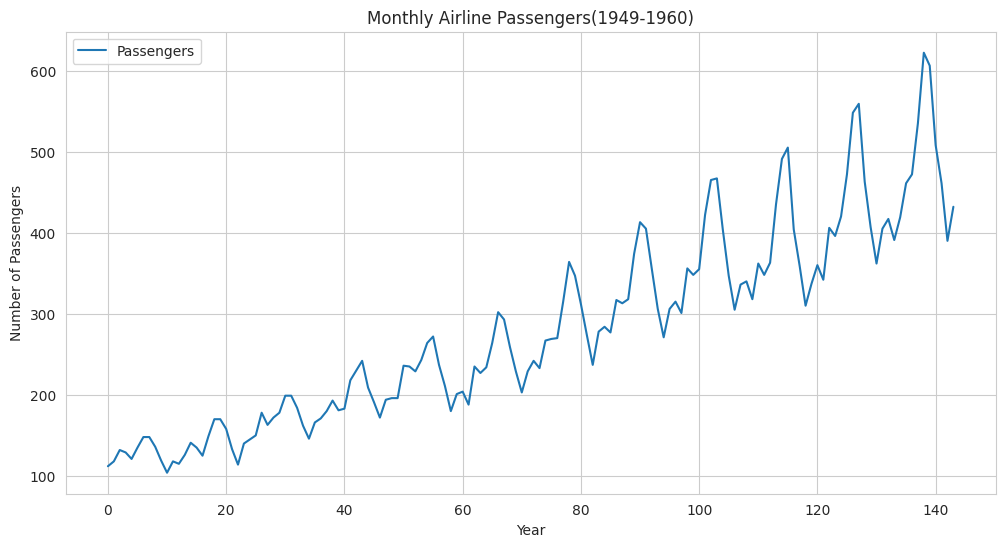

In [ ]:
df.plot()
plt.title('Monthly Airline Passengers(1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**sm.tsa.Seasonal_decompose:This Function from statsmodela lirary perfrom the decomposation**

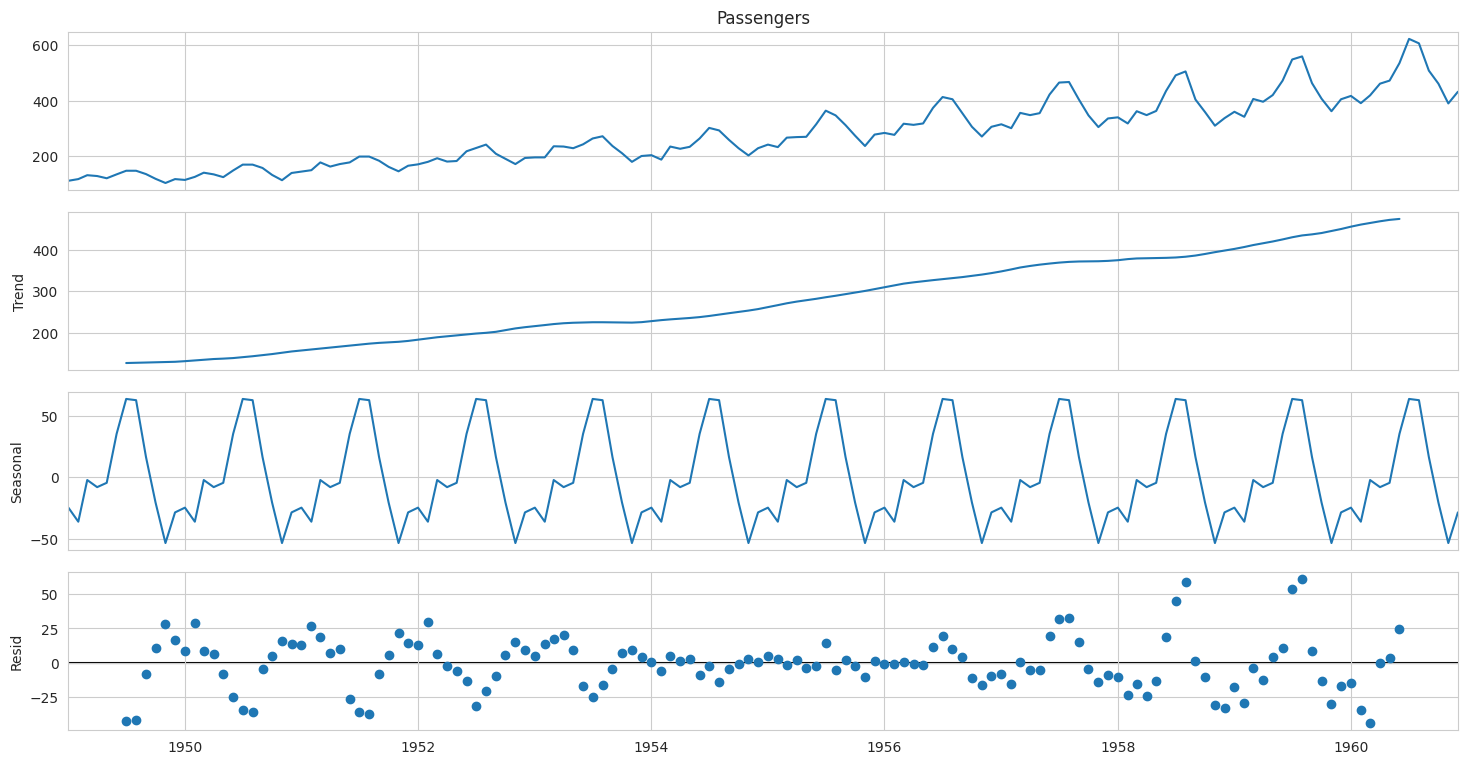

In [ ]:
#Convert 'Month' to datetime and set as index
# df['Month']=pd.to_datetime(df['Month'])
# df.set_index('Month',inplace=True)

import statsmodels.api as sm
#Decompose the time series to visualize its components
decomposition=sm.tsa.seasonal_decompose(df['Passengers'],model='additive')

fig=decomposition.plot()
fig.set_size_inches(15,8)
plt.show()

In [ ]:
def test_statinarity(timeseries):
  # Perform Dickey-Full test:
  dftest=adfuller(timeseries,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
  print(dfoutput)

test_statinarity(df['Passengers'])

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


**Step 4: Making the Series Stationry**

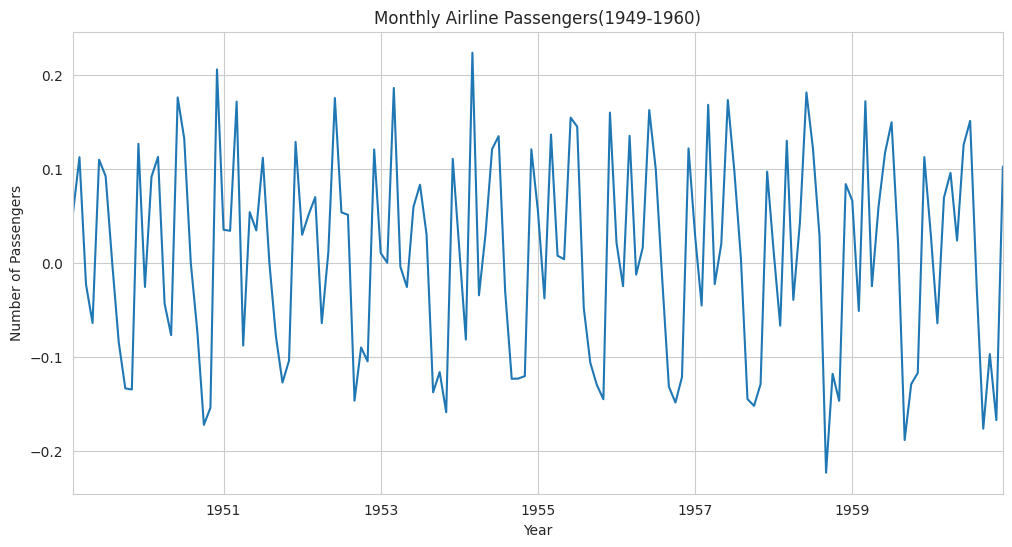

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
df_log=np.log(df['Passengers'])

## Applying Diffrencing to remove the trends
df_log_diff=df_log.diff().dropna()

##Plot the stationary series
df_log_diff.plot()
plt.title('Monthly Airline Passengers(1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

#Reset for Stationaries
test_statinarity(df_log_diff)



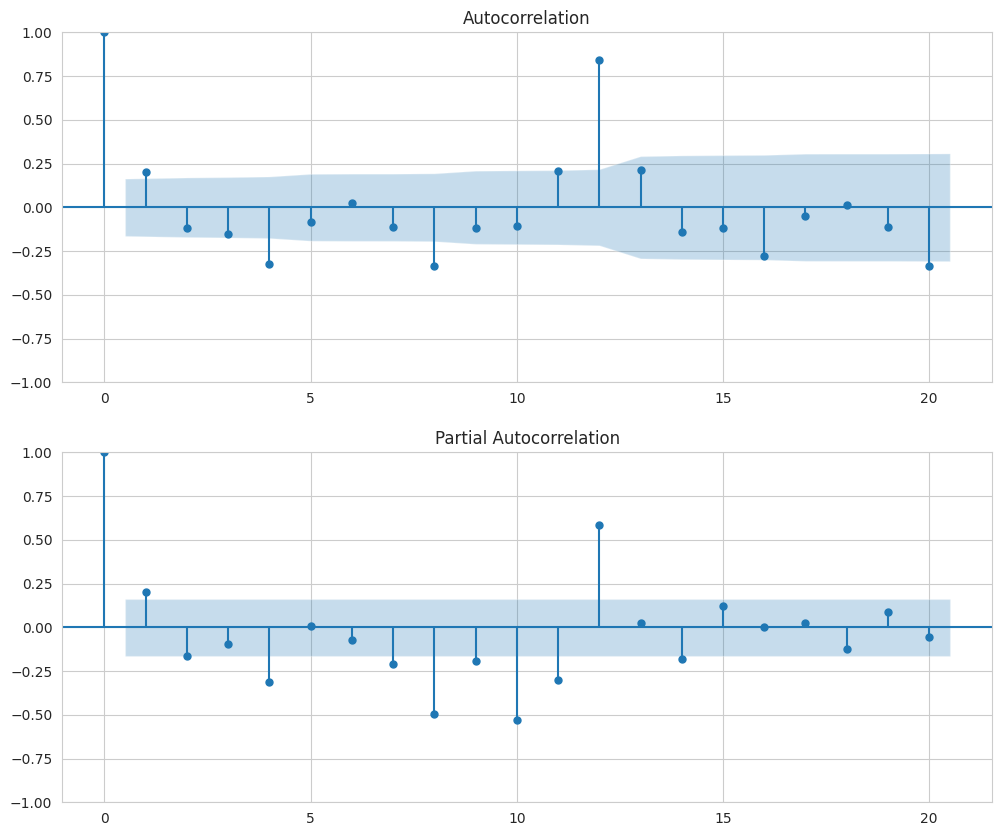

In [ ]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,10))
plot_acf(df_log_diff,lags=20,ax=ax1)
plot_pacf(df_log_diff,lags=20,ax=ax2)
plt.show()

**Step 6: Building the ARIMA Model**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


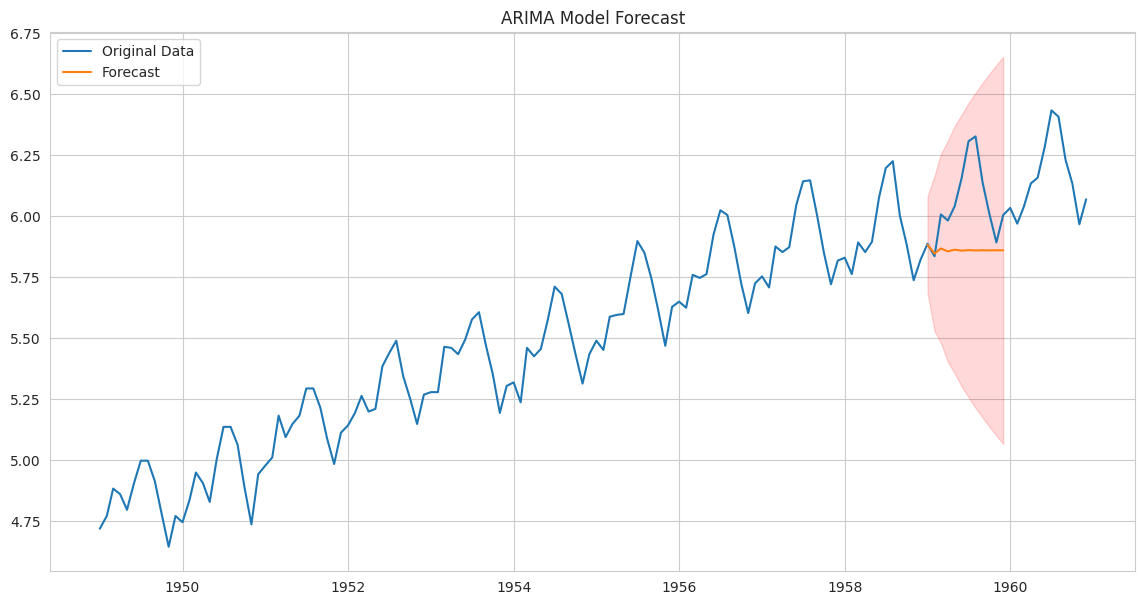

In [ ]:
## Split the data into training and test sets
trai_data=df_log[:'1958']
test_data=df_log['1959']

#Build ARIMA Model
model=ARIMA(trai_data,order=(1,1,1))
model_fit=model.fit()

#Get Forecast
forecast=model_fit.get_forecast(steps=len(test_data))
forecast_ci=forecast.conf_int()

#plot the forecast
plt.figure(figsize=(14,7))
plt.plot(df_log,label='Original Data')
plt.plot(forecast.predicted_mean,label='Forecast')
plt.fill_between(forecast_ci.index,forecast_ci.iloc[:,0],forecast_ci.iloc[:,1],color='r',alpha=0.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

**Step 7:Building a SARIMA Model for Seasonality**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


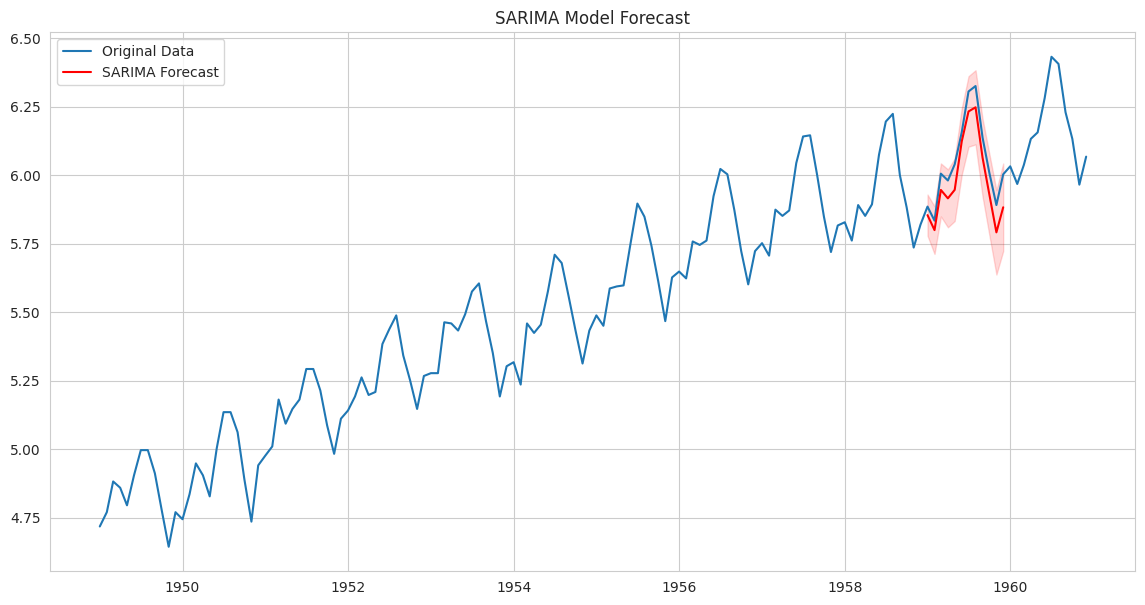

In [ ]:
#Build SARIMA Model
#We can find the optional p,D,Q through a grid search,but common values are 1
sarima_model=sm.tsa.statespace.SARIMAX(trai_data,order=(1,1,1),
                                       seasonal_order=(1,1,1,12),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
sarima_model_fit=sarima_model.fit()

#Get Forecast
sarima_forecast=sarima_model_fit.get_forecast(steps=len(test_data))
sarima_forecast_ci=sarima_forecast.conf_int()

#Plot the forecast
plt.figure(figsize=(14,7))
plt.plot(df_log,label='Original Data')
plt.plot(sarima_forecast.predicted_mean,label='SARIMA Forecast',color='r')
plt.fill_between(sarima_forecast_ci.index,sarima_forecast_ci.iloc[:,0],sarima_forecast_ci.iloc[:,1],color='r',alpha=0.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**Step 8: Final Evaluation**

SARIMA Model RMSE: 31.101083


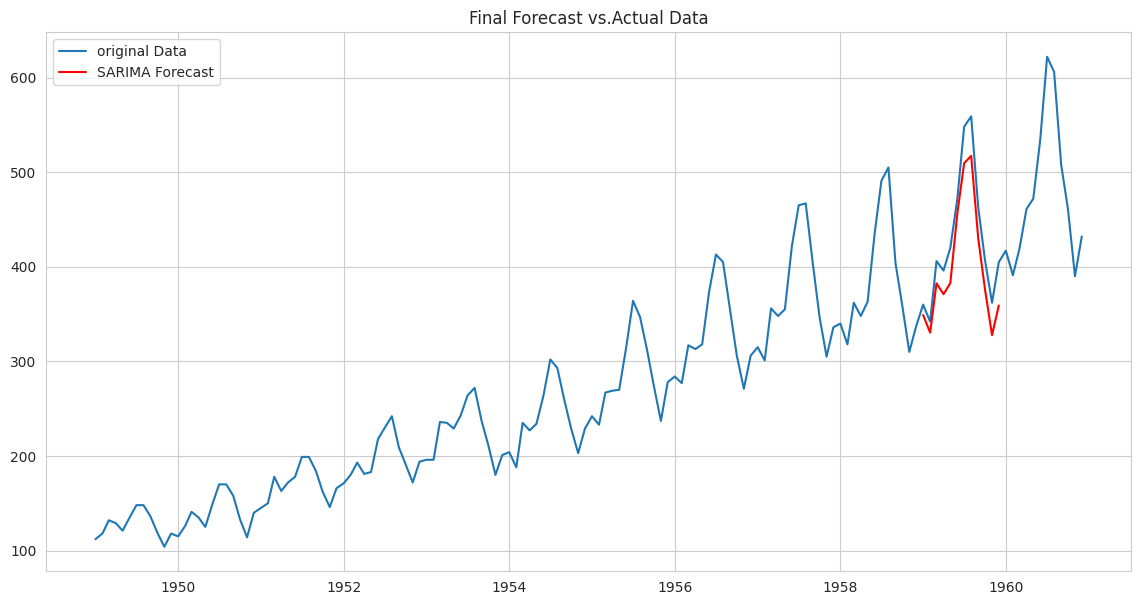

In [ ]:
#Reverse the log transformation to get passenger numbers
original_test_data=np.exp(test_data)
sarima_predictions=np.exp(sarima_forecast.predicted_mean)

#Calculate RMSE
rmse=np.sqrt(mean_squared_error(original_test_data,sarima_predictions))
print(f'SARIMA Model RMSE: {rmse:2f}')

#Plot final results
plt.figure(figsize=(14,7))
plt.plot(df['Passengers'],label='original Data')
plt.plot(sarima_predictions,label='SARIMA Forecast',color='r')
plt.title('Final Forecast vs.Actual Data')
plt.legend()
plt.show()